In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [46]:
# import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # image loading preprocessing & applying operations like rotation etc
from tensorflow.keras.applications import InceptionResNetV2 # the model that we are training
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# dense : fully connected for classification
# GlobalAveragePooling2D : reduces feature maps to a single vector
# dropout : randomly drops images during training to avoid overfitting
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # updates model weights
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# earlystopping -> stops training if the model doesnt improvise
# modelcheckpoint -> saves the best performing weight
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
# path to dataset
dataset = '/content/drive/MyDrive/TrashType_Image_Dataset'

In [5]:
image_size = (224,224)
batch_size=32
Epochs = 20
learning_Rate = 1e-4

In [20]:
# using imagedatagenerator -  learns to classify a much broader range of image appearances
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20, # detect obj regardless of orientation
    width_shift_range=0.2, # randomly shifts horizontally
    height_shift_range=0.2, # randomly shifts vertically
    shear_range=0.2, # helps train in geometric distortions
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
# using flow from directory function to load data from the directory and splitting into training and validation
train_gen = datagen.flow_from_directory(
    dataset,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
    shuffle=True
)

Found 1985 images belonging to 6 classes.
Found 494 images belonging to 6 classes.


In [37]:
# loading the base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable =False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=learning_Rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = '/content/drive/MyDrive/best_trash_type_model.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True,mode='max',verbose=1)


In [38]:
# train the model and perform feature extraction
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=Epochs,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2298 - loss: 2.3247 
Epoch 1: val_accuracy improved from -inf to 0.39474, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1339s 21s/step - accuracy: 0.2302 - loss: 2.3224 - val_accuracy: 0.3947 - val_loss: 1.5620
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3029 - loss: 1.8598
Epoch 2: val_accuracy improved from 0.39474 to 0.54858, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 647s 10s/step - accuracy: 0.3035 - loss: 1.8586 - val_accuracy: 0.5486 - val_loss: 1.2968
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4108 - loss: 1.5868
Epoch 3: val_accuracy improved from 0.54858 to 0.57085, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 631s 10s/step - accuracy: 0.4111 - loss: 1.5862 - val_accuracy: 0.5709 - val_loss: 1.1504
Epoch 4/20
63/63 ━━━━━━━━━━━━━━

In [39]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=learning_Rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = Epochs + fine_tune_epochs

In [40]:
# testing and evaluating model
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop, checkpoint]
)

Epoch 20/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6591 - loss: 0.9732
Epoch 20: val_accuracy improved from 0.73279 to 0.74089, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 729s 11s/step - accuracy: 0.6596 - loss: 0.9722 - val_accuracy: 0.7409 - val_loss: 0.7302
Epoch 21/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7563 - loss: 0.7389
Epoch 21: val_accuracy improved from 0.74089 to 0.74494, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 736s 11s/step - accuracy: 0.7562 - loss: 0.7390 - val_accuracy: 0.7449 - val_loss: 0.7105
Epoch 22/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7723 - loss: 0.6804
Epoch 22: val_accuracy improved from 0.74494 to 0.75506, saving model to /content/drive/MyDrive/best_trash_type_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 702s 11s/step - accuracy: 0.7722 - loss: 0.6806 - val_accuracy: 0.7551 - val_loss: 0.6978
Epoch 23/30
63/63 ━━━━━━━

In [42]:
final_model_path = '/content/drive/MyDrive/final_trash_type_model.keras'
model.save(final_model_path)

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


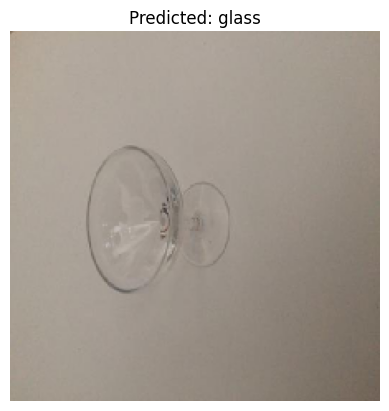


Predicted Class: glass
Confidence Scores: [[0.00516682 0.7299262  0.00515992 0.01499551 0.24081843 0.00393315]]


In [47]:
# testing
model_path = '/content/drive/MyDrive/best_trash_type_model.keras'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

img_path = '/content/drive/MyDrive/TrashType_Image_Dataset/glass/glass_015.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
predicted_label = class_labels[predicted_class_index]

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()

print(f"\nPredicted Class: {predicted_label}")
print(f"Confidence Scores: {predictions}")


Model loaded successfully!
Found 494 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.8588 - loss: 0.4526

Validation Accuracy: 80.77%
Validation Loss: 0.6165
16/16 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.91      0.90      0.91        71
       glass       0.86      0.84      0.85       100
       metal       0.82      0.88      0.85        82
       paper       0.78      0.85      0.81       118
     plastic       0.79      0.71      0.75        96
       trash       0.48      0.41      0.44        27

    accuracy                           0.81       494
   macro avg       0.77      0.76      0.77       494
weighted avg       0.81      0.81      0.81       494



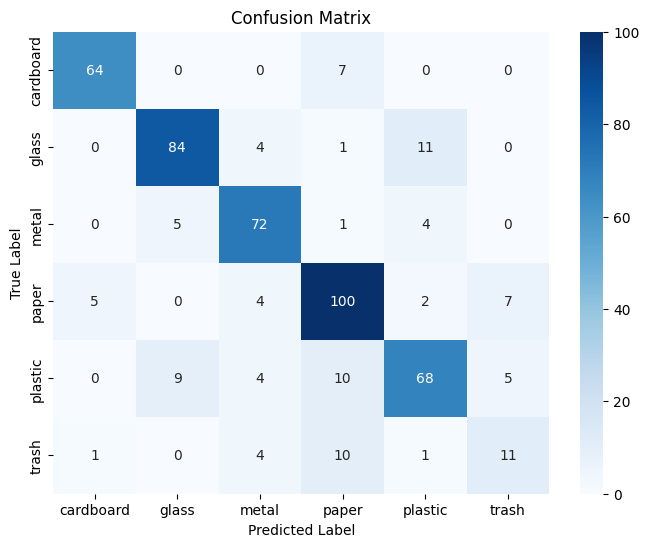

In [48]:
model_path = '/content/drive/MyDrive/best_trash_type_model.keras'
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

dataset = '/content/drive/MyDrive/TrashType_Image_Dataset'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    dataset,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

val_loss, val_accuracy = model.evaluate(val_gen)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

predictions = model.predict(val_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes

class_labels = list(val_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
